# XGBoost First Look

- [analytics vidyha overview](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [parameters for xgboost](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md)

In [1]:
import numpy as np
import pandas as pd
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

seed = 0

/Library/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Importing the Engineered Feature Set

In [2]:
from feature_eng import feature_eng_02

# load the dataset
path = '/Users/jonbruno/Documents/Python/Kaggle/Housing/data/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

# perform all feature engineering
train,test = feature_eng_02(train,test)

X = train.drop(['Id','SalePrice'],axis=1)
y = train.SalePrice
X_test = test.drop(['Id'],axis=1)

### Simple XGBoost Model - No Tuning
[Mini Course](http://machinelearningmastery.com/xgboost-python-mini-course/)

In [3]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=test_size,
                                    random_state=seed)
# fit model no training data
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
mse = mean_squared_error(y_test, y_pred)
print("MSE: %s" % (mse))


MSE: 0.0160925632873


### Tuning a Model with GridSearch Cross Validation

In [30]:
# "learning_rate":[0.01, 0.1, 0.3, 0.9]
param_grid =  {"max_depth":[2,3,5,8],
               "n_estimators":[100,200,400,800]}
model = xgboost.XGBRegressor(learning_rate=0.1)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
grid_search = GridSearchCV(model, param_grid,
                            scoring="neg_mean_squared_error",
                            n_jobs=1,
                            cv=kfold)

grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.018653 using {'n_estimators': 400, 'max_depth': 2}
-0.020534 (0.005664) with: {'n_estimators': 100, 'max_depth': 2}
-0.019129 (0.006158) with: {'n_estimators': 200, 'max_depth': 2}
-0.018653 (0.006497) with: {'n_estimators': 400, 'max_depth': 2}
-0.018817 (0.006109) with: {'n_estimators': 800, 'max_depth': 2}
-0.019980 (0.005602) with: {'n_estimators': 100, 'max_depth': 3}
-0.019183 (0.005663) with: {'n_estimators': 200, 'max_depth': 3}
-0.019152 (0.005609) with: {'n_estimators': 400, 'max_depth': 3}
-0.019411 (0.005671) with: {'n_estimators': 800, 'max_depth': 3}
-0.019791 (0.005663) with: {'n_estimators': 100, 'max_depth': 5}
-0.019409 (0.005549) with: {'n_estimators': 200, 'max_depth': 5}
-0.019430 (0.005652) with: {'n_estimators': 400, 'max_depth': 5}
-0.019457 (0.005644) with: {'n_estimators': 800, 'max_depth': 5}
-0.020518 (0.005689) with: {'n_estimators': 100, 'max_depth': 8}
-0.020441 (0.005677) with: {'n_estimators': 200, 'max_depth': 8}
-0.020458 (0.005665) with: {'n

In [31]:
grid_result.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [33]:
# evaluate the tuned model
y_pred = grid_result.predict(X_test)

# evaluate predictions
mse = mean_squared_error(y_test, y_pred)
print("MSE: %s" % (mse))

MSE: 0.0160513557296


In [ ]:
# best general results depth=3, rate=0.1, n_estimators=400

### Data Prep XGBoost
http://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

### Feature Importance
[Mini Course](http://machinelearningmastery.com/xgboost-python-mini-course/)

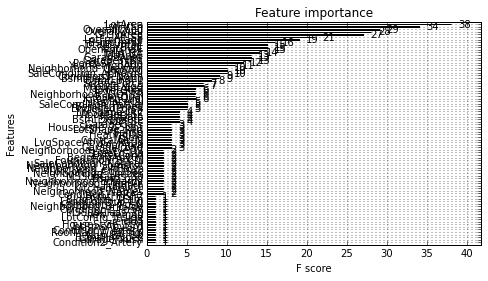

In [4]:
# NOTE: there are no feature_importances_ for Regression, instead  shows f-score
# print(model.feature_importance_)
xgboost.plot_importance(model)
plt.show()

### Feature Selection
http://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/


Another feature selection strategy is presented in the above link. The strategy steps through threshold values, corresponding to feature importances, and selects which features to include in a model. Thus we can use a pre-trained model to then test subsets of features and see how well the model performs.

### Classificaiton

In [5]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# this works for classification
thresholds = np.sort(model.feature_importances_)
thresholds = np.sort(model)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    

### Regression - Needs a Fix

#### Challanges with Regression Feature Selection and the F-score
regression doesnt explicetly let you grab f-scores which is helpful in liu of feature importance
[this blog](https://czong.wordpress.com/2016/07/14/xgboost-how-to-get-feature-importance-use-get_fscore-within-sklearn-wrapper/) provides more detail. **However I haven't invested the time to ferret this functionality out**


In [ ]:
# NEED TO FIX THIS TO USE GET_FSCORE!!
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    
    # for a regression model as per here
    mse = mean_squared_error(y_test, y_pred)
    print("Thresh=%.3f, n=%d, MSE: %.2f%%" % (thresh, select_X_train.shape[1], mse*100.0))

### Monitoring Performance and Early Stopping
- [Early Stopping](http://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)
- [Model Evaluation](http://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/)

In [9]:
# oos evaluation and early stopping are parameters of the fit method
# we can specify the evaluation set or out of sample set as below
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10,
                            eval_metric="rmse",
                            eval_set=eval_set,
                            verbose=True)

[0]	validation_0-rmse:10.376
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.34042
[2]	validation_0-rmse:8.40845
[3]	validation_0-rmse:7.56973
[4]	validation_0-rmse:6.81483
[5]	validation_0-rmse:6.1377
[6]	validation_0-rmse:5.52612
[7]	validation_0-rmse:4.97736
[8]	validation_0-rmse:4.48228
[9]	validation_0-rmse:4.03725
[10]	validation_0-rmse:3.63502
[11]	validation_0-rmse:3.27389
[12]	validation_0-rmse:2.95062
[13]	validation_0-rmse:2.65808
[14]	validation_0-rmse:2.39619
[15]	validation_0-rmse:2.16033
[16]	validation_0-rmse:1.94709
[17]	validation_0-rmse:1.7555
[18]	validation_0-rmse:1.58438
[19]	validation_0-rmse:1.42883
[20]	validation_0-rmse:1.28876
[21]	validation_0-rmse:1.1642
[22]	validation_0-rmse:1.05165
[23]	validation_0-rmse:0.951037
[24]	validation_0-rmse:0.859813
[25]	validation_0-rmse:0.777856
[26]	validation_0-rmse:0.703857
[27]	validation_0-rmse:0.637806
[28]	validation_0-rmse:0.577884
[29]	validation_0-rmse:0.525135
[30]	validat

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [15]:
# suggested evaluation is good old cross validation
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(model, X, y, cv=kfold, scoring="neg_mean_squared_error")
print("Neg MSE: %.2f%% (%.2f%%)" % (-results.mean()*100, results.std()*100))

Neg MSE: 1.72% (0.19%)


### Hyperparameter Tuning
- http://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
- http://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
- http://machinelearningmastery.com/stochastic-gradient-boosting-xgboost-scikit-learn-python/

After a cursery review of the above these techniques all rely heavily on grid search. However the individual scores are all captured and plotted which allows for a nice viszualization of the differences and performance trends, rather than a point estimate of optimal parameters. 

## Building out the GridSearchCV visualizations is a great expansion of the tuning functionality

#### Additional Resources
- tuning the learning rate, [suggested strategy from Owen Zhang](https://www.slideshare.net/ShangxuanZhang/winning-data-science-competitions-presented-by-owen-zhang)


### Learning Curves

In [16]:
from ml_helpers.model_eval import plot_validation_curve

/Library/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


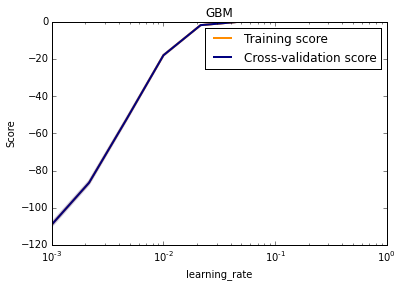

In [17]:
val1 = plot_validation_curve(estimator = model,
                            title = "GBM",
                            param_name = "learning_rate",
                            X = X_train,
                            y = y_train,
                            param_range=np.logspace(-3,0,10),
                            cv=10,
                            scoring="neg_mean_squared_error",
                            njobs=1)

### Visualize the Tree
http://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

In [ ]:
# for details on the parameters themselves see:
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md